In [16]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


Create INSAR Dataset

In [17]:
# Set data cube dimension
n_azimuth=2000
n_range=1000
n_time=4

In [18]:
# signal
signal = np.zeros((n_time,n_azimuth,n_range))
signal[0,:,:] = np.tile(np.linspace(0,np.pi,num=n_range), (n_azimuth,1))
for i in range(1,n_time):
    signal[i,:,:] = signal[0,:,:]+i

# noise
np.random.seed(0)
noise = np.random.rand(n_time,n_azimuth,n_range)*2*np.pi

# obs
obs = signal + noise

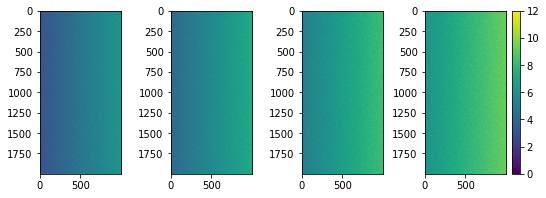

In [19]:
fig, ax = plt.subplots(1,n_time)
fig.set_size_inches(9,3)
for i in range(n_time):
    im = ax[i].imshow(obs[i], vmin=0, vmax=12)
plt.colorbar(im)

In [20]:
ds = xr.Dataset(
    data_vars=dict(
        obs=(["time", "azimuth", "range"], obs),
    ),
    coords=dict(
        azimuth=np.arange(n_azimuth),
        range=np.arange(n_range),
        time=np.arange(n_time),
    ),
)
ds

<xarray.Dataset>
Dimensions:  (time: 4, azimuth: 2000, range: 1000)
Coordinates:
  * azimuth  (azimuth) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * range    (range) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * time     (time) int64 0 1 2 3
Data variables:
    obs      (time, azimuth, range) float64 3.448 4.497 3.794 ... 8.004 7.702

Create sample contextual raster data-set

In [21]:
# Set contextual raster data cube dimension
n_azimuth_ci=750
n_range_ci=750
n_time_ci=4

In [22]:
# signal
signal = np.zeros((n_time_ci,n_azimuth_ci,n_range_ci))
signal[0,:,:] = np.tile(np.linspace(0,np.pi,num=n_range_ci), (n_azimuth_ci,1))
for i in range(1,n_time_ci):
    signal[i,:,:] = signal[0,:,:]+i

# noise
np.random.seed(0)
noise = np.random.rand(n_time_ci,n_azimuth_ci,n_range_ci)*2*np.pi

# obs
obs_ci = signal + noise + 100

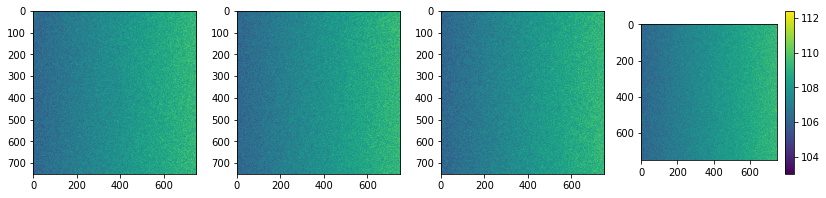

In [23]:
fig, ax = plt.subplots(1,n_time_ci)
fig.set_size_inches(14,3)
for i in range(n_time_ci):
    im = ax[i].imshow(obs_ci[i])
plt.colorbar(im)

In [24]:
ds_ci = xr.Dataset(
    data_vars=dict(
        CI_temp=(["time", "azimuth", "range"], obs_ci),
    ),
    coords=dict(
        azimuth=np.arange(n_azimuth_ci)*(n_azimuth/n_azimuth_ci),
        range=np.arange(n_range_ci)*(n_range/n_range_ci),
        time=np.arange(n_time_ci)*(n_time/n_time_ci),
    ),
)
ds_ci

<xarray.Dataset>
Dimensions:  (time: 4, azimuth: 750, range: 750)
Coordinates:
  * azimuth  (azimuth) float64 0.0 2.667 5.333 ... 1.992e+03 1.995e+03 1.997e+03
  * range    (range) float64 0.0 1.333 2.667 4.0 ... 994.7 996.0 997.3 998.7
  * time     (time) float64 0.0 1.0 2.0 3.0
Data variables:
    CI_temp  (time, azimuth, range) float64 103.4 104.5 103.8 ... 110.4 107.2

Select closest CI for INSAR coordinates with xarray_sel( ) from raster SAR data (i.e with sparse representation)

*** Note that the resultant coordinate system is of the CI dataset from which we are selecting

In [25]:
ds_ci_sel = ds_ci.sel(azimuth = ds['azimuth'], range = ds['range'], method = 'nearest')
ds_ci_sel

<xarray.Dataset>
Dimensions:  (time: 4, azimuth: 2000, range: 1000)
Coordinates:
  * azimuth  (azimuth) float64 0.0 0.0 2.667 ... 1.997e+03 1.997e+03 1.997e+03
  * range    (range) float64 0.0 1.333 2.667 2.667 ... 996.0 997.3 998.7 998.7
  * time     (time) float64 0.0 1.0 2.0 3.0
Data variables:
    CI_temp  (time, azimuth, range) float64 103.4 104.5 103.8 ... 107.2 107.2

Select closest CI for SAR coordinates and reindex to SAR coordinates with xarray_reindex( ) from raster SAR data (i.e with sparse representation)

*** Note that the resultant coordinate system is now the same as the SAR coordinate system

In [26]:
ds_ci_reind = ds_ci.reindex(azimuth = ds['azimuth'], range = ds['range'], method = 'nearest')
ds_ci_reind

<xarray.Dataset>
Dimensions:  (azimuth: 2000, range: 1000, time: 4)
Coordinates:
  * azimuth  (azimuth) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * range    (range) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * time     (time) float64 0.0 1.0 2.0 3.0
Data variables:
    CI_temp  (time, azimuth, range) float64 103.4 104.5 103.8 ... 107.2 107.2

Interpolation can be performed using the inbuilt `interp()` function

In [27]:
ds_ci_interp = ds_ci.interp(azimuth = ds['azimuth'], range = ds['range'], method = 'nearest')
ds_ci_interp

<xarray.Dataset>
Dimensions:  (time: 4, azimuth: 2000, range: 1000)
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0
  * azimuth  (azimuth) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * range    (range) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
Data variables:
    CI_temp  (time, azimuth, range) float64 103.4 104.5 104.5 ... nan nan nan

CI raster data import for point-set from SAR data-set

In [28]:
# Select the low std pixels
mask = ds.obs.std(axis=0)<0.5
print(mask.sum())
ds_masked = ds.where(mask)
pointset = ds_masked.stack(points=('azimuth', 'range'))
pointset = pointset.dropna('points', subset=['obs'])
pointset

<xarray.DataArray 'obs' ()>
array(34885)


<xarray.Dataset>
Dimensions:  (time: 4, points: 34885)
Coordinates:
  * time     (time) int64 0 1 2 3
  * points   (points) object MultiIndex
  * azimuth  (points) int64 0 0 0 0 0 0 0 ... 1999 1999 1999 1999 1999 1999 1999
  * range    (points) int64 20 71 163 165 244 281 ... 743 768 769 850 905 948
Data variables:
    obs      (time, points) float64 6.212 3.168 5.956 ... 6.254 8.466 6.026

In [29]:
pointset.points['azimuth']

<xarray.DataArray 'azimuth' (points: 34885)>
array([   0,    0,    0, ..., 1999, 1999, 1999])
Coordinates:
  * points   (points) object MultiIndex
  * azimuth  (points) int64 0 0 0 0 0 0 0 ... 1999 1999 1999 1999 1999 1999 1999
  * range    (points) int64 20 71 163 165 244 281 ... 743 768 769 850 905 948

In [30]:
ds_ci_ps_sel = ds_ci.sel(azimuth = pointset.points['azimuth'], range = pointset.points['range'], method = 'nearest')
ds_ci_ps_sel

<xarray.Dataset>
Dimensions:  (time: 4, points: 34885)
Coordinates:
    azimuth  (points) float64 0.0 0.0 0.0 0.0 ... 1.997e+03 1.997e+03 1.997e+03
    range    (points) float64 20.0 70.67 162.7 165.3 ... 769.3 850.7 905.3 948.0
  * time     (time) float64 0.0 1.0 2.0 3.0
    points   (points) object (0, 20) (0, 71) ... (1999, 905) (1999, 948)
Data variables:
    CI_temp  (time, points) float64 100.6 100.9 106.5 ... 106.6 108.1 106.4

In [31]:
ds_ci_ps_interp = ds_ci.interp(azimuth = pointset.points['azimuth'], range = pointset.points['range'], method = 'nearest')
ds_ci_ps_interp

<xarray.Dataset>
Dimensions:  (time: 4, points: 34885)
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0
  * azimuth  (points) int64 0 0 0 0 0 0 0 ... 1999 1999 1999 1999 1999 1999 1999
  * range    (points) int64 20 71 163 165 244 281 ... 743 768 769 850 905 948
  * points   (points) object MultiIndex
Data variables:
    CI_temp  (time, points) float64 100.6 100.9 106.5 103.2 ... nan nan nan nan

We can assign the resulting interpolated data-array to our original point-set

*** Note that this would not carry over the coordinate system if `sel()` function was used to select nearest neighbour.

In [32]:
pointset['CI_temp'] = ds_ci_ps_interp['CI_temp']
pointset

<xarray.Dataset>
Dimensions:  (time: 4, points: 34885)
Coordinates:
  * time     (time) int64 0 1 2 3
  * points   (points) object MultiIndex
  * azimuth  (points) int64 0 0 0 0 0 0 0 ... 1999 1999 1999 1999 1999 1999 1999
  * range    (points) int64 20 71 163 165 244 281 ... 743 768 769 850 905 948
Data variables:
    obs      (time, points) float64 6.212 3.168 5.956 ... 6.254 8.466 6.026
    CI_temp  (time, points) float64 100.6 100.9 106.5 103.2 ... nan nan nan nan

Interpolate with lat and lon as coordinates

In [33]:
ds_wll = xr.Dataset(
    data_vars=dict(
        obs=(["time", "azimuth", "range"], obs),
    ),
    coords=dict(
        azimuth=np.arange(n_azimuth),
        range=np.arange(n_range),
        time=np.arange(n_time),
        lat = np.arange(n_azimuth)*2,
        lon = np.arange(n_range)*2
    ),
)
ds_wll

<xarray.Dataset>
Dimensions:  (time: 4, azimuth: 2000, range: 1000, lat: 2000, lon: 1000)
Coordinates:
  * azimuth  (azimuth) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * range    (range) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * time     (time) int64 0 1 2 3
  * lat      (lat) int64 0 2 4 6 8 10 12 ... 3986 3988 3990 3992 3994 3996 3998
  * lon      (lon) int64 0 2 4 6 8 10 12 ... 1986 1988 1990 1992 1994 1996 1998
Data variables:
    obs      (time, azimuth, range) float64 3.448 4.497 3.794 ... 8.004 7.702

In [34]:
ds_ci_wll = xr.Dataset(
    data_vars=dict(
        CI_temp=(["time", "lat", "lon"], obs_ci),
    ),
    coords=dict(
        azimuth=np.arange(n_azimuth_ci)*(n_azimuth/n_azimuth_ci),
        range=np.arange(n_range_ci)*(n_range/n_range_ci),
        time=np.arange(n_time_ci)*(n_time/n_time_ci),
        lat=np.arange(n_azimuth_ci)*2*(n_azimuth/n_azimuth_ci),
        lon=np.arange(n_range_ci)*2*(n_range/n_range_ci),
    ),
)
ds_ci_wll

<xarray.Dataset>
Dimensions:  (time: 4, lat: 750, lon: 750, azimuth: 750, range: 750)
Coordinates:
  * azimuth  (azimuth) float64 0.0 2.667 5.333 ... 1.992e+03 1.995e+03 1.997e+03
  * range    (range) float64 0.0 1.333 2.667 4.0 ... 994.7 996.0 997.3 998.7
  * time     (time) float64 0.0 1.0 2.0 3.0
  * lat      (lat) float64 0.0 5.333 10.67 ... 3.984e+03 3.989e+03 3.995e+03
  * lon      (lon) float64 0.0 2.667 5.333 8.0 ... 1.992e+03 1.995e+03 1.997e+03
Data variables:
    CI_temp  (time, lat, lon) float64 103.4 104.5 103.8 ... 107.1 110.4 107.2

In [35]:
ds_ci_w_latlon_interp = ds_ci_wll.interp(lat = ds_wll['lat'], lon = ds_wll['lon'], method = 'nearest')
ds_ci_w_latlon_interp

<xarray.Dataset>
Dimensions:  (time: 4, lat: 2000, lon: 1000, azimuth: 750, range: 750)
Coordinates:
  * azimuth  (azimuth) float64 0.0 2.667 5.333 ... 1.992e+03 1.995e+03 1.997e+03
  * range    (range) float64 0.0 1.333 2.667 4.0 ... 994.7 996.0 997.3 998.7
  * time     (time) float64 0.0 1.0 2.0 3.0
  * lat      (lat) int64 0 2 4 6 8 10 12 ... 3986 3988 3990 3992 3994 3996 3998
  * lon      (lon) int64 0 2 4 6 8 10 12 ... 1986 1988 1990 1992 1994 1996 1998
Data variables:
    CI_temp  (time, lat, lon) float64 103.4 104.5 104.5 103.8 ... nan nan nan

Conclusions:

Xarray provides multiple options to go from one raster coordinate system to another which is useful in the context of obtaining contextual information from a raster data-set (`ds_ci`) to our SAR data-set (`ds`). The methods that could be applied are:

 - `ds_ci.sel()`: where `ds_ci` is the xarray data-set and this can be used to select points that match with our `ds` coordinates on the basis of nearest neighbour (method = nearest), forward neighbour (method = ffill), or backward neighbour (method = bfill). This does not involve any reindexing which means that the final coordinate labels will remain as in `ds_ci` dataset

 - `ds_ci.reindex()`: performs a similar operation to `ds.sel()` but performs a reindexing operation to move from `ds_ci` coordinate system to `ds` coordinate system.
    
 - `ds_ci.interp()`: when a perfect match is not found, it performs a interpolation using `scipy.interpolate` function to obtain the values at the `ds` coordinates.

Both `ds.sel()` and `ds.interp()` work on pointset like data as shown in the example and can be used to extract contextual information for a specific, arbitrary set of points. By using `ds.sel()` we obtain the data with both the original coordinate system of `ds_ci` as well as the SAR coordinate system in points. When we assign this variable to our space-time matrix, the original coordinate system gets discarded unless intentionally carried over.

For certain situations where alternate dimensions (say (`lat, lon`) instead of (`azimuth, range`)) is prefered, then there are two approaches that can be taken:

    1) Provide in the original definition of the data-set both sets of coordinates as dimensions. Following this, all the above methods can be applied - the dimensions of the data array needs to carefully defined.
    
    2) Provide (`x,y`) as primary dimensions with other sets (`lat, lon`) or (`azimuth, range`) as coordinates which can be set, when required, as the primary dimension following which interpolation/selection can be performed.

The second method provides maximum flexbility as new coordinates can be added at any time and used to reference the values. Additionally, the definition of dimensions need to carefully carried in the first case in order to ensure that interpolation/selection happens on the right coordinates.